In [1]:
import sympy
from sympy import *
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

In [2]:
x1, x2, x3, x4 = symbols('x_1 x_2 x_3 x_4', real=True)
i = Idx('i', (1, 11))
a = Function('a')
b = Function('b')
A = [0.1957, 0.1947, 0.1735, 0.16, 0.0844, 0.0627, 0.0456, 0.0342, 0.0323, 0.0235, 0.0246];
B = [1/0.25, 1/0.50, 1/1.0, 1/2.0, 1/4.0, 1/6.0, 1/8.0, 1/10.0, 1/12.0, 1/14.0, 1/16.0]

#eq = sympy.Sum(sympy.Pow(a(i) - ((x1 * (1 + x2 * b(i))) / (1 + x3 * b(i) + x4 * sympy.Pow(b(i), 2))), 2),(i, 1, 11)).doit()
eq = sympy.Sum(sympy.Pow(a(i) - x1 *((b(i)**2 + b(i)*x2) / (b(i)**2 + b(i)*x3 + x4)), 2),(i, 1, 11)).doit()

eq = eq.replace(a, lambda i: A[i - 1])
eq = eq.replace(b, lambda i: B[i - 1])
var = [x1, x2, x3, x4]

In [3]:
ai = symbols("a_i", real = True)
bi = symbols("b_i", real = True)
f = sympy.Sum(sympy.Pow(ai - x1 *((bi**2 + bi*x2) / (bi**2 + bi*x3 + x4)), 2),(i, 1, 11))
f

Sum((a_i - x_1*(b_i**2 + b_i*x_2)/(b_i**2 + b_i*x_3 + x_4))**2, (i, 1, 11))

In [4]:
class MinimizerCalculator:
    equation: Equality
    step: int = 0
    variables: List[Symbol]

    def __init__(self, equation: Equality, variables: List[Symbol]):
        self.equation = equation
        self.variables = variables

    def calculate(self, position: Array) -> Array:
        pass;

    def evaluateEq(self, position: Array) -> float:
        return self.equation.evalf(subs={self.variables[x]: position[x] for x in range(len(position))})

In [5]:
class ConjugateGradientCalculator(MinimizerCalculator):
    gradientEq: ImmutableDenseNDimArray
    dk = None
    aPrecesion = 10

    def __init__(self, equation: Equality, variables: List[Symbol]):
        super().__init__(equation, variables)
        self.gradientEq = sympy.derive_by_array(equation, variables)

    def calculate(self, position: Array) -> Array:
        gCurrent = self.evaluateGradient(position)
        if gCurrent == [0 for i in range(len(self.variables))]:
            return position
        if self.dk is None:
            self.dk = -gCurrent
        ak = self.calculateStepSize(position, self.dk)
        if ak is None:
            return None
        xNext = position + ak * self.dk
        gNext = self.evaluateGradient(xNext)
        b = self.calculateB(gCurrent, gNext)
        if b is None:
            return None
        self.dk = -gNext + (b * self.dk)
        return xNext

    def calculateB(self, gCurrent, gNext):
        pass;

    def calculateStepSize(self, initialPosition: Array, direction: Array) -> float:
        minValue = self.evaluateEq(initialPosition)
        minStep = 0
        deepStep = 0
        while minStep == 0:
            deepStep = deepStep + 1
            prevValue = None
            for i in range(self.aPrecesion):
                step = ((i - 1) / (self.aPrecesion ** deepStep))
                value = self.evaluateEq(initialPosition + direction * step)
                if prevValue == value:
                    return None
                prevValue = value
                if value < abs(minValue):
                    minValue = value
                    minStep = step
        return minStep

    def evaluateGradient(self, position: Array) -> Array:
        return Array(
            [self.gradientEq[i].evalf(subs={self.variables[x]: position[x] for x in range(len(position))}) for i in
             range(len(position))])

In [ ]:
class HestenesStiefelCalculator(ConjugateGradientCalculator):
    def __init__(self, equation: Equality, variables: List[Symbol]):
        super().__init__(equation, variables)

    def calculateB(self, gCurrent, gNext):
        a = Matrix(gNext).transpose() * Matrix(gNext - gCurrent)
        b = Matrix(self.dk).transpose() * Matrix(gNext - gCurrent)
        return a[0] / b[0]

In [67]:
gcurr = MatrixSymbol("g_i",4,1)
gnext = MatrixSymbol("g_(i+1)",4,1)
dk = MatrixSymbol("d_k",4,1)
display((gcurr.transpose()*(gnext-gcurr))/(dk.transpose()*(gnext-gcurr)))
display((gnext.transpose()*(gnext-gcurr))/(gcurr.transpose() *  gcurr))
display(gnext.transpose() * gnext /(gcurr.transpose() *gcurr))
display(gnext.transpose() * gnext /(dk.transpose() * (gnext-gcurr)))

g_i.T*(g_(i+1) - g_i)*(d_k.T*(g_(i+1) - g_i))**(-1)

g_(i+1).T*(g_(i+1) - g_i)*(g_i.T*g_i)**(-1)

g_(i+1).T*g_(i+1)*(g_i.T*g_i)**(-1)

g_(i+1).T*g_(i+1)*(d_k.T*(g_(i+1) - g_i))**(-1)

In [7]:
class PolakRibiereCalculator(ConjugateGradientCalculator):
    def __init__(self, equation: Equality, variables: List[Symbol]):
        super().__init__(equation, variables)

    def calculateB(self, gCurrent, gNext):
        a = Matrix(gNext).transpose() * Matrix(gNext - gCurrent)
        b = Matrix(gCurrent).transpose() * Matrix(gCurrent)
        return a[0] / b[0]

In [8]:
class FletcherReevesCalculator(ConjugateGradientCalculator):
    def __init__(self, equation: Equality, variables: List[Symbol]):
        super().__init__(equation, variables)

    def calculateB(self, gCurrent, gNext):
        a = Matrix(gNext).transpose() * Matrix(gNext)
        b = Matrix(gCurrent).transpose() * Matrix(gCurrent)
        return a[0] / b[0]

In [9]:
class DaiYuanCalculator(ConjugateGradientCalculator):
    def __init__(self, equation: Equality, variables: List[Symbol]):
        super().__init__(equation, variables)

    def calculateB(self, gCurrent, gNext):
        if all(v == 0 for v in (gNext - gCurrent)):
            return None
        a = Matrix(gNext).transpose() * Matrix(gNext)
        b = Matrix(self.dk).transpose() * Matrix(gNext - gCurrent)
        return a[0] / b[0]

In [10]:
class NewtonRaphsonCalculator(MinimizerCalculator):
    gradientEq: ImmutableDenseNDimArray
    hessianEq: List[ImmutableDenseNDimArray]
    def __init__(self, equation: Equality, variables: List[Symbol]):
        super().__init__(equation, variables)
        self.gradientEq = derive_by_array(self.equation, self.variables)
        self.hessianEq = [derive_by_array(i, self.variables) for i in self.gradientEq]

    def calculate(self, position: Array) -> Array:
        evaluateGradient = self.evaluateGradient(position)
        evaluateHessian = self.evaluateHessian(position)
        if evaluateHessian.det() == 0:
            return None
        deltaPosition = evaluateHessian.inv() * Matrix(evaluateGradient)
        return position - Array(deltaPosition.transpose().tolist()[0])

    def evaluateGradient(self, position: Array) -> Array:
        return Array(
            [self.gradientEq[i].evalf(subs={self.variables[x]: position[x] for x in range(len(position))}) for i in
             range(len(position))])

    def evaluateHessian(self, position: Array) -> Matrix:
        return Matrix([[self.hessianEq[i][j].evalf(subs={self.variables[x]: position[x] for x in range(len(position))})
                        for i in range(len(position))] for j in range(len(position))])

In [11]:
class EquationSolver:
    minimizer: MinimizerCalculator
    stepSize: int
    position: [Array]
    name: str
    evaluation: [float]
    timePassed: [float]
    
    def __init__(self, minimizer:MinimizerCalculator, stepSize:int, initialPosition:List[float], name:str):
        self.minimizer = minimizer
        self.stepSize = stepSize
        self.name = name
        self.position = [Array(initialPosition)]
        self.evaluation = [minimizer.evaluateEq(initialPosition)]
        self.timePassed = []

    def calculate(self):
        for i in range(self.stepSize):
            start = time.time()
            result = self.minimizer.calculate(self.position[-1])
            if result is None:
                break
            self.timePassed.append(time.time() - start)
            self.position.append(result)
            self.evaluation.append(self.minimizer.evaluateEq(result))
            if self.evaluation[-1] < 0.0001:
                break

    def evaluationPlot(self):
        xpoints = np.array([i for i in range(len(self.evaluation))])
        ypoints = np.array([self.evaluation[i] for i in range(len(self.evaluation))])
        plt.plot(xpoints, ypoints, label = self.name)
        
    def deltaEvaluationPlot(self):
        xpoints = np.array([i for i in range(len(self.evaluation) - 1)])
        ypoints = np.array([abs(self.evaluation[i] - self.evaluation[i + 1]) for i in range(len(self.evaluation) - 1)])
        plt.plot(xpoints, ypoints, label = self.name)

    def maxTime(self):
        return max(self.timePassed)

    def minTime(self):
        return min(self.timePassed)

    def averageTime(self):
        return sum(self.timePassed) / len(self.timePassed)

    def getStep(self, error:float):
        for i in range(len(self.evaluation)):
            if self.evaluation[i] < error:
                return i
        return None

    def print(self):
        display(self.name)
        display("step: " + str(len(self.position)))
        display("x :" + str(self.position[-1]))
        display("ev :" + str(self.evaluation[-1]))

In [12]:
#initialPosition = [random.random() * 0.42, random.random() * 0.42, random.random() * 0.42, random.random() * 0.42]
initialPosition1 = [0.3604731246866024, 0.07230024599267677, 0.11897895468122173, 0.045488678141934774]
initialPosition2 = [0.03259413754069159, 0.22363517468946045, 0.3678804141000155, 0.21481580185423677]
initialPosition3 = [0.26529854910838047, 0.1427029905292762, 0.12562171017636237, 0.3589400996677316]


In [13]:
initialPosition = initialPosition1
stepSize = 1000
h = EquationSolver(HestenesStiefelCalculator(eq, var), stepSize, initialPosition, "Hestenes-Stiefel")

p = EquationSolver(PolakRibiereCalculator(eq, var), stepSize, initialPosition, "Polak-Ribiere")

f = EquationSolver(FletcherReevesCalculator(eq, var), stepSize, initialPosition, "Fletcher-Reeves")

d = EquationSolver(DaiYuanCalculator(eq, var), stepSize, initialPosition, "Dai-Yuan")

n = EquationSolver(NewtonRaphsonCalculator(eq, var), stepSize, initialPosition, "Newton-Raphson")

solvings = [h,p,f,d,n]

In [14]:
h.calculate()

In [15]:
p.calculate()

In [16]:
f.calculate()

In [17]:
d.calculate()

In [18]:
n.calculate()

In [19]:
solvings = [h,p,f,d,n]
for i in solvings:
    i.print()

'Hestenes-Stiefel'

'step: 235'

'x :[0.19283350326289, 0.190836181075396, 0.123117836987507, 0.135765882266028]'

'ev :0.000307485987808412'

'Polak-Ribiere'

'step: 302'

'x :[0.19283343310502, 0.190836692745037, 0.123117398957881, 0.135766192074864]'

'ev :0.000307485987805985'

'Fletcher-Reeves'

'step: 1001'

'x :[0.192833527175225, 0.190837348735729, 0.123118864011061, 0.135766320116918]'

'ev :0.000307485987822920'

'Dai-Yuan'

'step: 211'

'x :[0.192833453481504, 0.19083617014236, 0.123117245568834, 0.135765965118894]'

'ev :0.000307485987805627'

'Newton-Raphson'

'step: 62'

'x :[0, -0.0836537252426657, -0.190783238888725, 0.00895510234235279]'

'ev :0.148413180000000'

In [42]:
for error in [0.01, 0.001, 0.0004, 0.00031, 0.000308]:
    display("")
    display("Absolute Error: " + str(error))
    for solve in solvings:
        i = solve.getStep(error)
        if i is not None:
            display(solve.name)
            display("Step: " + str(i))
        else:
            display(solve.name)
            display("Not reach below " + str(error))

''

'Absolute Error: 0.01'

'Hestenes-Stiefel'

'Step: 3'

'Polak-Ribiere'

'Step: 3'

'Fletcher-Reeves'

'Step: 2'

'Dai-Yuan'

'Step: 2'

'Newton-Raphson'

'Not reach below 0.01'

''

'Absolute Error: 0.001'

'Hestenes-Stiefel'

'Step: 7'

'Polak-Ribiere'

'Step: 4'

'Fletcher-Reeves'

'Step: 5'

'Dai-Yuan'

'Step: 4'

'Newton-Raphson'

'Not reach below 0.001'

''

'Absolute Error: 0.0004'

'Hestenes-Stiefel'

'Step: 9'

'Polak-Ribiere'

'Step: 6'

'Fletcher-Reeves'

'Step: 7'

'Dai-Yuan'

'Step: 5'

'Newton-Raphson'

'Not reach below 0.0004'

''

'Absolute Error: 0.00031'

'Hestenes-Stiefel'

'Step: 20'

'Polak-Ribiere'

'Step: 18'

'Fletcher-Reeves'

'Step: 82'

'Dai-Yuan'

'Step: 22'

'Newton-Raphson'

'Not reach below 0.00031'

''

'Absolute Error: 0.000308'

'Hestenes-Stiefel'

'Step: 62'

'Polak-Ribiere'

'Step: 38'

'Fletcher-Reeves'

'Step: 165'

'Dai-Yuan'

'Step: 31'

'Newton-Raphson'

'Not reach below 0.000308'

## ay = plt.gca()
ay.set_yscale('log')
ay.set_xscale('log', base = 10)

plt.xlabel("Steps")
plt.ylabel("Evaluation error")
plt.title("Evaluation error by step")
for i in solvings:
 i.evaluationPlot()

plt.legend()
plt.show()

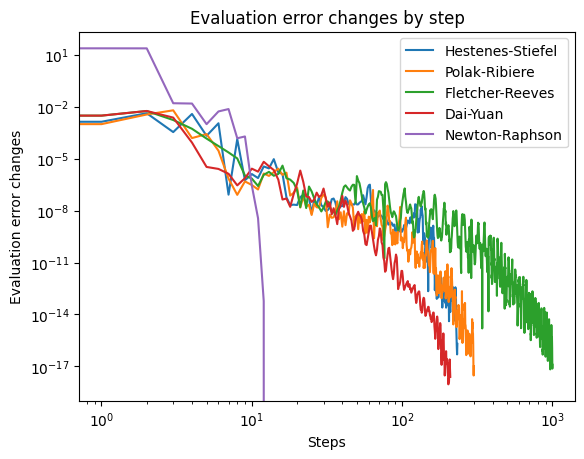

In [44]:

ay = plt.gca()
ay.set_yscale('log')
ay.set_xscale('log', base = 10)

plt.xlabel("Steps")
plt.ylabel("Evaluation error changes")
plt.title("Evaluation error changes by step")

for i in solvings:
 i.deltaEvaluationPlot()

plt.legend()
plt.show()

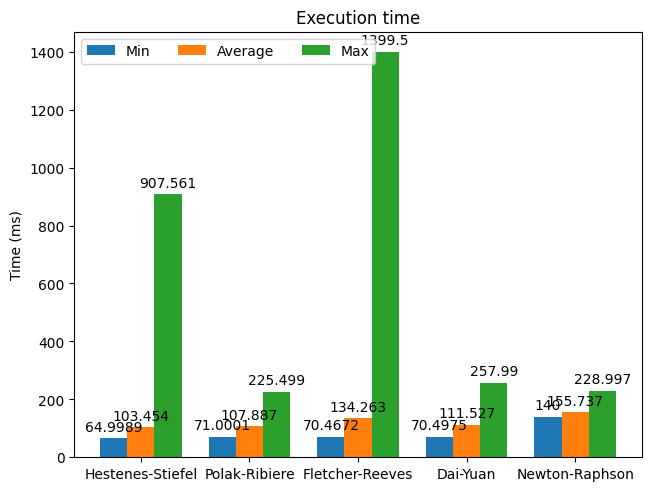

In [23]:
species = tuple(i.name for i in solvings)
penguin_means = {
    'Min': tuple(i.minTime() * 1000 for i in solvings),
    "Average": tuple(i.averageTime() * 1000 for i in solvings),
    'Max': tuple(i.maxTime() * 1000 for i in solvings),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (ms)')
ax.set_title('Execution time')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

In [24]:
h.position[-1]

[0.19283350326289, 0.190836181075396, 0.123117836987507, 0.135765882266028]

In [25]:
p.position[-1]

[0.19283343310502, 0.190836692745037, 0.123117398957881, 0.135766192074864]

In [26]:
h.minimizer.evaluateEq(Array([0.192833, 0.190836, 0.123117, 0.135766]))

0.000307485988655873

In [27]:
h.minimizer.evaluateEq(Array([0.046, 1.745, -0.218, 0.154]))

0.0351428374439997